In [2]:
import pandas as pd
import numpy as np
#import geopandas as gpd
import matplotlib.pyplot as plt
import pdb
import os
import sqlalchemy
from matplotlib import collections  as mc
from sklearn.cluster import *
from sklearn.neighbors import *
import scipy.stats as stats
import tensorly as tl
from tensorly.decomposition import parafac, tucker, non_negative_parafac, non_negative_tucker

Using numpy backend.


In [3]:
tl.set_backend("mxnet")

Using mxnet backend.


In [4]:
%matplotlib inline
np.seterr(divide='raise',invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

Data downloaded from:

https://sites.google.com/site/yangdingqi/home/foursquare-dataset

In [5]:
nyc = pd.read_table("dataset_tsmc2014/dataset_TSMC2014_NYC.txt", header=None, parse_dates=[7], encoding = "ISO-8859-1")
tokyo = pd.read_table("dataset_tsmc2014/dataset_TSMC2014_TKY.txt", header=None, parse_dates=[7], encoding = "ISO-8859-1")

In [6]:
cols = ['userid', 'venusid', 'venus_category', 'venus_category_name', 'lat', 'lon', 'tzoffset_min', 'utc']
nyc.columns = cols
tokyo.columns = cols

In [7]:
def prepare_data(dat):
    dat['local_time'] = dat.utc+list(map(lambda x: pd.Timedelta(x, 'm'), dat.tzoffset_min))
    dat['week_hour'] = dat.local_time.dt.weekday*24 + dat.local_time.dt.hour
    dat['month'] = dat.local_time.dt.month
    dat = dat.sort_values(['userid', 'local_time'])
    #dat.groupby(['userid', 'venus_category_name', 'week_hour']).count()
    return dat

In [8]:
nyc = prepare_data(nyc)
tokyo = prepare_data(tokyo)

In [9]:
nyc['season'] = pd.cut(nyc.month, bins=(0,2,5,8,11), labels=('winter', 'spring', 'summer', 'fall'))
# fill in Dec
nyc['season'] = nyc['season'].fillna('winter')

In [10]:
x=pd.DataFrame(nyc.groupby(['season', 'venus_category_name']).count().userid)

x.columns=['counts']

countbymonth = x.reset_index().pivot_table('counts', 'season', 'venus_category_name')#.fillna(0)

In [11]:
countbymonth

venus_category_name,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Travel Lounge,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Winery,Wings Joint,Zoo
season,,,,,,,,,,,,,,,,,,,,,
winter,NaN,5.0,585.0,747.0,8.0,7.0,NaN,31.0,5.0,3.0,...,9.0,4.0,198.0,58.0,24.0,12.0,39.0,6.0,17.0,35.0
spring,2.0,23.0,1010.0,1359.0,38.0,9.0,5.0,162.0,7.0,7.0,...,3.0,9.0,475.0,154.0,30.0,14.0,64.0,8.0,65.0,37.0
summer,1.0,10.0,842.0,1036.0,9.0,5.0,5.0,131.0,6.0,6.0,...,9.0,4.0,191.0,102.0,29.0,11.0,52.0,11.0,44.0,18.0
fall,1.0,2.0,415.0,559.0,7.0,6.0,1.0,53.0,2.0,6.0,...,17.0,3.0,207.0,36.0,40.0,5.0,25.0,6.0,23.0,14.0


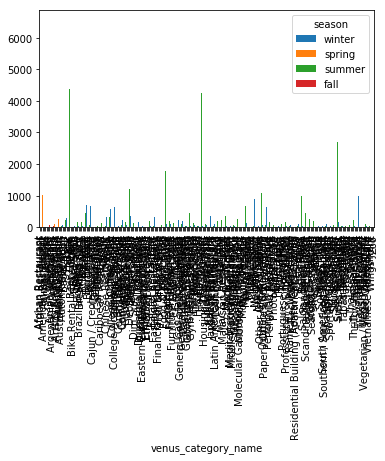

In [12]:
countbymonth.T.plot(kind='bar')

In [13]:
freqbymonth = (countbymonth.T/countbymonth.sum(axis=1)).T

In [14]:
freqbymonth.fillna(1e-6, inplace=True)

In [15]:
freqbymonth

venus_category_name,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Travel Lounge,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Winery,Wings Joint,Zoo
season,,,,,,,,,,,,,,,,,,,,,
winter,0.000001,0.000121,0.014115,0.018024,0.000193,0.000169,0.000001,0.000748,0.000121,0.000072,...,0.000217,0.000097,0.004777,0.001399,0.000579,0.000290,0.000941,0.000145,0.000410,0.000844
spring,0.000022,0.000253,0.011108,0.014946,0.000418,0.000099,0.000055,0.001782,0.000077,0.000077,...,0.000033,0.000099,0.005224,0.001694,0.000330,0.000154,0.000704,0.000088,0.000715,0.000407
summer,0.000016,0.000160,0.013432,0.016527,0.000144,0.000080,0.000080,0.002090,0.000096,0.000096,...,0.000144,0.000064,0.003047,0.001627,0.000463,0.000175,0.000830,0.000175,0.000702,0.000287
fall,0.000031,0.000062,0.012819,0.017267,0.000216,0.000185,0.000031,0.001637,0.000062,0.000185,...,0.000525,0.000093,0.006394,0.001112,0.001236,0.000154,0.000772,0.000185,0.000710,0.000432


In [16]:
# kl divergence
kldiv = np.zeros((freqbymonth.shape[0], freqbymonth.shape[0]))
# correlation
cov = np.zeros((freqbymonth.shape[0], freqbymonth.shape[0]))
# calculate pairwise kl divergence
for i in range(freqbymonth.shape[0]):
    for j in range(i, freqbymonth.shape[0]):
        kldiv[i][j] = stats.entropy(freqbymonth.iloc[i], freqbymonth.iloc[j])
        kldiv[j][i] = stats.entropy(freqbymonth.iloc[j], freqbymonth.iloc[i])
        cov[i][j] = np.corrcoef(freqbymonth.iloc[i], freqbymonth.iloc[j])[0][1]

From the correlation matrix, looks like people checkins doesn't depends much on seasons

In [17]:
cov

array([[ 1.        ,  0.96948856,  0.97764556,  0.99034261],
       [ 0.        ,  1.        ,  0.99361238,  0.9750123 ],
       [ 0.        ,  0.        ,  1.        ,  0.98153946],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [18]:
kldiv = pd.DataFrame(kldiv)

In [19]:
kldiv.columns = freqbymonth.index
kldiv.index = freqbymonth.index

In [20]:
kldiv

season,winter,spring,summer,fall
season,,,,
winter,0.000000,0.063217,0.047997,0.032153
spring,0.055169,0.000000,0.019219,0.041515
summer,0.051813,0.022137,0.000000,0.040676
fall,0.031623,0.045629,0.038876,0.000000


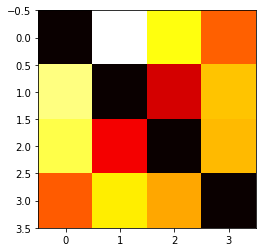

In [21]:
plt.imshow(kldiv, cmap='hot', interpolation='nearest')

In [22]:
pd.DataFrame(x.groupby(level=0, as_index=False).apply(lambda x: x['counts']/x.counts.sum())).to_clipboard()

# Prepare training and test data
TODO: use different spliting method?

In [23]:
train_test_time_split = pd.to_datetime('2012-12-31')

nyc_train, nyc_test = nyc[nyc.local_time < train_test_time_split], nyc[nyc.local_time >= train_test_time_split]

# temporal activity preference

In [24]:
uservenushour_tenor = nyc_train.groupby(['userid', 'venus_category_name', 'week_hour']).count()['utc']
uservenushour_tenor.name = 'count'

In [25]:
uservenushour_tenor = pd.DataFrame(uservenushour_tenor).unstack().fillna(0).unstack().fillna(0)

In [138]:
# from index to userid, venuse_names
userids = np.array(uservenushour_tenor.index)

venus_names = np.array(uservenushour_tenor.columns.levels[2])

In [150]:
# map userid to array index in the tenor's user dimension
id2idx = np.zeros(userids.max()+1, dtype=int)

id2idx[userids]=np.arange(len(id2idx))

In [220]:
HOURS_PER_WEEK = 168

In [221]:
# reshape into tenor of user x hour x tenus
uvh = uservenushour_tenor.values.reshape((uservenushour_tenor.shape[0], HOURS_PER_WEEK, 
                                          uservenushour_tenor.shape[1]//HOURS_PER_WEEK))

In [216]:
def tenor_model(uvh, latent_dimension):
    ## tenor CP decomposition model
    factors = non_negative_parafac(tl.tensor(uvh), latent_dimension, 200, 'svd')
    # model reconstructed uvh tensor
    uvh_hat = tl.kruskal_to_tensor(factors)
    uvh_hat_normalized = uvh_hat.asnumpy() / uvh_hat.sum(axis=[2]).asnumpy()[:,:,np.newaxis]
    return uvh_hat_normalized

In [218]:
# the latent dimension of CP decomposition
latent_dimension = 64

In [219]:
uvh_hat_normalized = tenor_model(uvh, latent_dimension)

In [222]:
venus_names[np.argsort(uvh_hat_normalized[0, 110, :])[-10:]]

array(['Subway', 'American Restaurant', 'Drugstore / Pharmacy',
       'Residential Building (Apartment / Condo)', 'Clothing Store',
       'Coffee Shop', 'Building', 'Park', 'Food & Drink Shop', 'Bar'], dtype=object)

In [223]:
# top one prediction
predicted_venusid = uvh_hat_normalized[id2idx[nyc_test.userid.values], nyc_test.week_hour.values, :].argmax(axis=1)

In [224]:
predicted_venus = venus_names[predicted_venusid.astype(int)]

In [225]:
predicted_venus[:30]

array(['Home (private)', 'Gym / Fitness Center', 'Subway',
       'Gym / Fitness Center', 'Bar', 'Subway', 'Subway',
       'Gym / Fitness Center', 'Home (private)', 'Gym / Fitness Center',
       'Gym / Fitness Center', 'Gym / Fitness Center',
       'Gym / Fitness Center', 'Gym / Fitness Center',
       'Gym / Fitness Center', 'Gym / Fitness Center', 'Subway', 'Bar',
       'Bar', 'Food & Drink Shop', 'Home (private)', 'Bar', 'Bar',
       'Food & Drink Shop', 'Food & Drink Shop', 'Gym / Fitness Center',
       'Gym / Fitness Center', 'Train Station', 'Train Station',
       'Gym / Fitness Center'], dtype=object)

In [226]:
nyc_test.venus_category_name.head()

205373    Department Store
205384            Building
205418         Coffee Shop
205785              Subway
206048     Thai Restaurant
Name: venus_category_name, dtype: object

In [227]:
nyc_test.head(n=20)

,userid,venusid,venus_category,venus_category_name,lat,lon,tzoffset_min,utc,local_time,week_hour,month,season
205373,2,4531059cf964a520683b1fe3,4bf58dd8d48988d1f6941735,Department Store,40.762325,-73.967814,-300,2013-01-02 17:39:53,2013-01-02 12:39:53,60,1,winter
205384,2,50a430bfe4b0f010d751e3a5,4bf58dd8d48988d130941735,Building,40.764655,-73.970741,-300,2013-01-02 18:19:51,2013-01-02 13:19:51,61,1,winter
205418,2,4a871b30f964a5209a0220e3,4bf58dd8d48988d1e0931735,Coffee Shop,40.741396,-74.004818,-300,2013-01-02 19:52:22,2013-01-02 14:52:22,62,1,winter
205785,2,4b8f50d9f964a520365133e3,4bf58dd8d48988d1fd931735,Subway,40.646099,-73.902669,-300,2013-01-03 15:13:27,2013-01-03 10:13:27,82,1,winter
206048,2,4e7bb781887742fc66380d56,4bf58dd8d48988d149941735,Thai Restaurant,40.634026,-74.026825,-300,2013-01-03 23:56:45,2013-01-03 18:56:45,90,1,winter
206529,2,4b7ecc2cf964a520420030e3,4bf58dd8d48988d1e0931735,Coffee Shop,40.606937,-74.162751,-300,2013-01-04 19:33:58,2013-01-04 14:33:58,110,1,winter
206820,2,4b740a6af964a5200bc52de3,4bf58dd8d48988d179941735,Bagel Shop,40.626531,-74.129270,-300,2013-01-05 06:35:04,2013-01-05 01:35:04,121,1,winter
208135,2,4a3d735cf964a5204ba21fe3,4bf58dd8d48988d1f6941735,Department Store,40.751502,-73.982719,-300,2013-01-07 16:36:38,2013-01-07 11:36:38,11,1,winter
208173,2,3fd66200f964a520def11ee3,4bf58dd8d48988d163941735,Park,40.735282,-73.990403,-300,2013-01-07 17:41:00,2013-01-07 12:41:00,12,1,winter
208261,2,4c26b50fa852c9287f33e76c,4f2a25ac4b909258e854f55f,Neighborhood,40.643657,-73.900673,-300,2013-01-07 20:13:30,2013-01-07 15:13:30,15,1,winter


In [228]:
np.unique(predicted_venus)

array(['American Restaurant', 'Arcade', 'Bank', 'Bar', 'Beach', 'Building',
       'Bus Station', 'Chinese Restaurant', 'Church', 'Coffee Shop',
       'College Academic Building', 'Deli / Bodega', 'Ferry',
       'Food & Drink Shop', 'Gym / Fitness Center', 'Home (private)',
       'Hotel', 'Light Rail', 'Medical Center', 'Neighborhood', 'Office',
       'Other Great Outdoors', 'Park', 'Road', 'Subway', 'Theater',
       'Train Station'], dtype=object)

In [229]:
np.sum(predicted_venus == nyc_test.venus_category_name)

5831

In [230]:
predicted_venus[predicted_venus == nyc_test.venus_category_name]

array(['Gym / Fitness Center', 'Gym / Fitness Center', 'Bar', ...,
       'Office', 'Bar', 'Office'], dtype=object)

In [187]:
nyc_test.shape

(23355, 12)

# locational activity preference

In [45]:
#dump training data for ELKI
nyc_train[['lat', 'lon']].to_csv('nyc_train.csv', header=None, index=None)

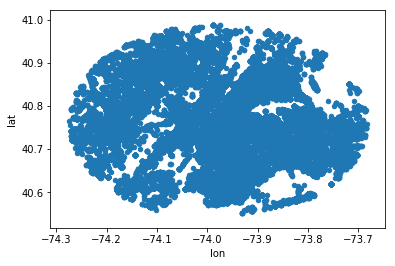

In [41]:
nyc_train[['lat', 'lon']].plot(x='lon', y='lat', kind='scatter')

In [43]:
nyc_train[['lat', 'lon']].describe()

,lat,lon
count,204073.000000,204073.000000
mean,40.753909,-73.974707
std,0.072787,0.085801
min,40.550852,-74.274766
25%,40.718110,-74.000633
50%,40.747845,-73.983473
75%,40.778790,-73.946209
max,40.988332,-73.683825


In [44]:
nyc_train.shape

(204073, 12)